## 3. Análisis de emociones en *tweets*

El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad de un trozo de texto, es decir, clasificar una determinada evaluación escrita (review ), en que una persona manifiesta una opinión, como positiva, negativa o neutral. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.

<img src="https://image.flaticon.com/sprites/new_packs/132222-color-emotions-assets.png" width="40%" />



Para esta actividad se trabajará con un datasets de tweets ofrecidos por CrowdFlower[[8]](#refs). Cada *tweet* está
asociado a una emoción en particular, donde el conjunto de emociones se trabajarán como mutuamente excluyentes, siendo un problema de múltiples clases.

Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv
```

Para aumentar la eficacia de las caracterı́sticas extraı́das es conveniente ejecutar algunas técnicas de pre-procesamiento básicas.

> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
df = pd.read_csv('text_emotion.csv')

df.shape
df.info('label')
df.groupby('sentiment')['sentiment'].count()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


sentiment
anger          110
boredom        179
empty          827
enthusiasm     759
fun           1776
happiness     5209
hate          1323
love          3842
neutral       8638
relief        1526
sadness       5165
surprise      2187
worry         8459
Name: sentiment, dtype: int64

In [2]:
df.dtypes

tweet_id      int64
sentiment    object
author       object
content      object
dtype: object

Abstract

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

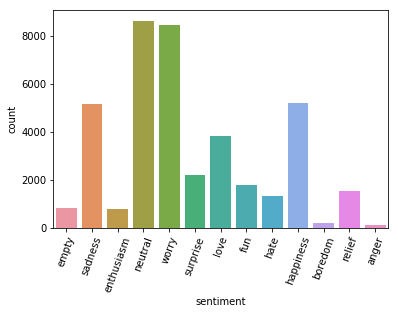

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x= "sentiment",data=df)
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 20
plt.xticks(rotation=70)


> b) Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos. Genere un conjunto de validación si estima conveniente.

In [30]:
import numpy as np
#a = np.seed(70)

df_test_star = df[df["sentiment"]=='empty'] #este df es espacial, al menos para mi hacer pruebas si alguno se parece 
df_clean= df.drop(['tweet_id', 'author' ],axis=1).values
df_clean_x = df.drop(['tweet_id', 'author', 'sentiment' ],axis=1).values
df_clean_y = df.drop(['tweet_id', 'author', 'content' ],axis=1).values
msk = np.random.rand(len(df)) < 0.8
#rows = [line.split(" ",1) for line in df.readlines()]
#df_train = pd.DataFrame(rows, columns=['sentiment','content'])
#df_train['Sentiment'] = pd.to_numeric(df_train['sentiment'])
df_train = df_clean[msk]#respaldo de los datos de entrenamiento
x_train = df_clean_x[msk]#training data
y_val = df_clean_y[msk]#validation set for our training data
df_val = df_clean[~msk]#respaldo para los datis de validacion
x_test = df_clean_x[~msk]
y_test = df_clean_y[~msk]
df_train.shape
print(df_train)


[['empty'
  '@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[']
 ['sadness'
  'Layin n bed with a headache  ughhhh...waitin on your call...']
 ['enthusiasm' 'wants to hang out with friends SOON!']
 ...
 ['neutral' '@JohnLloydTaylor']
 ['love' 'Happy Mothers Day  All my love']
 ['happiness'
  '@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEEP OUT MY NEW HIT SINGLES WWW.MYSPACE.COM/IPSOHOT I DEF. WAT U IN THE VIDEO!!']]


In [5]:
print(msk)
print(~msk)

[ True False  True ...  True  True  True]
[False  True False ... False False False]


c) Construya las representaciones de los datos con los que trabajará, ya sea para las entradas de los modelos como para las salidas. Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros.

In [59]:
y_val[y_val== 'empty'] = 0
y_val[y_val== 'sadness'] = 1
y_val[y_val== 'enthusiasm'] = 2
y_val[y_val== 'neutral'] = 3
y_val[y_val== 'worry'] = 4
y_val[y_val== 'surprise'] = 5
y_val[y_val== 'love'] = 6
y_val[y_val== 'fun'] = 7
y_val[y_val== 'hate'] = 8
y_val[y_val== 'happiness'] = 9
y_val[y_val== 'boredom'] = 10
y_val[y_val== 'relief'] = 11
y_val[y_val== 'anger'] = 12

for i in range(len(x_train)):
    print(x_train[i])
#classes  = pd.get_dummies(df, columns=["sentiment"]) #column to categorical
#classes = nuevo_df.drop(['tweet_id', 'author','content' ],axis=1)
#classes.head(6)



['@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[']
['Layin n bed with a headache  ughhhh...waitin on your call...']
['wants to hang out with friends SOON!']
['@dannycastillo We want to trade with someone who has Houston tickets, but no one will.']
["Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends"]
["I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!"]
['@charviray Charlene my love. I miss you']
["@kelcouch I'm sorry  at least it's Friday?"]
['cant fall asleep']
['Choked on her retainers']
['Ugh! I have to beat this stupid song to get to the next  rude!']
['@BrodyJenner if u watch the hills in london u will realise what tourture it is because were weeks and weeks late  i just watch itonlinelol']
['The storm is here and the electricity is gone']
['@PerezHilton lady gaga tweeted about not being impressed by her video leaking 

['@mikdev  i leave the 27th, back the 5th or 6th.']
['4am foodshopping cause I was sick all day and was in hospitals  being alone blows']
['wondering where all the money i earnt this financial year has gone... i can account for like 3 grand but wheres the rest']
['you forgot your fans too!  haha']
['http://twitpic.com/665to Less than 24 hours till the show! Oh and Lee broke his guitar at practice    http://twitpic.com/660vv']
['@heavenlykevinly You go to sleeeeeeepz']
['@arielleGore I so dont  And wtf. Whatthefuck. REALLY? Really? Are they trying to kill me? But i might be... Depends...']
['I just lost a fight against @hangy on Tweefight. I lost  Please revenge me! Try now http://tweefight.com/?opp=hangy']
['is seriously heartbroken!!!']
["@dragonflyeyes nick's voice still makes me wanna kill things"]
['@tonibraxton Will you ever come to SF Bay Area to preform, i feel left out']
['oh! i think i didnt do well on my photo editing for Db!  sorry :|']
['Aww sad @Ruthiexo09 now  stupid crap

['@ConcertJunkie &quot;I SAAAAAAID!!&quot; Haha. It kinda makes me sad though.  http://bit.ly/uJUA3']
['is leading dull life this Friday... Babysitting!']
['@nursebettie666 he is the meanest lil boy ever!!!!!!!!!! When I was a lil girl everyone loved me']
['planning June - lots of appointments. meeting, briefings and litte time to finish my reports']
["@vibzfabz Hey, you change your twitter account, and you didn't even tell me..."]
['so bored...']
['#freeagentapp free trial ran out today, cannot subscribe because Abby accidentally canceled my card - still waiting for a new one']
['You fooled me!']
['trying to get used to twitter, i have a cold']
["Rain stopped a few minutes ago. I noticed that every time I cheer for the rain while it's raining, it stops. I shall not cheer next time."]
['i really need to go and start some more revision,biology or chemistry today me thinks']
['Ready for the trip. Not ready to leave my baby!!!!']
['Guitar lessons tomorrow. ( I have to wake up early again.

["The JBs love to keep secrets!  'Oooooh!'"]
['Ugh going to town. I can never rest!  wants to go to tylers but who knows when i will get back. (exausted)']
["I've got a bit of neckache after going hard (not going home) at Alternative night. I mean I have to, it's nearly all over"]
['the puppy shall loose his um... manly parts today  poor guy....']
["@poppyscorner He steals my stuff, buries them under fence. Embarassing when it's the man returning them! Not much I can do about frogs."]
['greeeeeeeeeeeat  this summer i have four classes...if you know me...u know why']
['@jennyrae Wow, I really hope it gets better. Asthma sucks']
['TODAY FRIDAY: I really hope you will read my messages here and reply to me soon. I could not reach you by phone before you go to work.']
["@ElizabethN I may be in the US for it in which case I'll attend but if its off my own back I can't afford to go"]
["I'm going to blow ticketmaster up. I had 8th row tickets for @taylorswift13 and ticketmaster messed up. Just

['Awww sunthings wrong w/ my ubertwitter last nite.']
['am about to sell my Medieval trading pavillion... v sad']
['I REALLY  should have gone to the Chiropractor this week . . And today  my neck hurts so bad']
["Ordered a new computer! Unfortunately it won't get here until the end of June."]
['Two dozen roses sent  overnight and delivered this morning. Just found out the recipient is out of town!! Sad']
["Don't you hate it when you're left with one slice of bread left in the bag? Half sandwich."]
['I get to drive my dad to the airport so he can fly to Vegas for the WSOP... I wanna go to Vegas...']
['.. these holidays are soo boring..']
['Ewww just printed my new I.d badge thingie 4 work n eww my picture. I took so many n they were all ugly']
['just about to say goodbye to @karenbrady and @agneslikaite two of the best interns that Elevate have ever had']
['i have geographie next  and I HATE IT!!!!!!!']
["I guess this is soul searching time for me since I'm home alone &amp; no one's tal

['@electra126 As long as you take me with you']
['Haavent read the paper yet about the magic loss nor did i get to watch the game last night.... But i do know that we lost']
["Sitting next to a man with a Kindle II...I don't know if I've ever been this jealous"]
['i feel sick after that oreo and cheesecake milkskake  lol']
["I haven't logged onto Minto.com in like 3 months and what I saw upset me  Gotta do better!"]
["God I HATE scary movies. They are not fun at all. I'm such a wimpy."]
["@clinton_kelly Bummed about the maxi dresses!  I think they're so cute for summer but I'm only 5'4&quot;!"]
['@chaletlaforet shit that is awful... could not believe it at first... so sad']
['@honytawk why do we need to wait another year for toy story 3?!']
['@sbenzur haha! sorry to hear that']
['ebay should just die! after not using my account for 4 years, i cant unlock it. and their support is dead, aka: auto-hello-scripts']
["heading to Sam Adams Brewery... but can't sample it when I get there"]
["n

['@misamille Where are u  miss you I hope you are doing well *sending big hugs*']
["OK, home made pizza tonight, but horrors, I've run out of anchovies"]
["@nick_carter Gotta make the video public, dear. LOL ...can't see it."]
['ScREW MY PHONE. ITS BROKEN. DONT BOTHER TEXTING.']
['@nick_carter THE LINK DOESNT WOR']
["@_HarryKim OOC:  It's okay.  Maybe our schedules will work out soon."]
["Gotta go to the doctor this morning  i feel so sick right now. i can barely talk but i'm still yelling across the house lol"]
["@Pretty23rd I wasn't feeling it"]
['@gfalcone601 giii help me  i really wana find a gorgeous dress for prom, not long, mid length or short, anywhere in the uk. please help']
['@anz_rocks19  i have to break the twitterparty... im off home soon']
['UGH I missed the POTUS @ MY Five Guys!!!! 2 blocks from my house and 3 blocks from my job.  http://www.politico.com/politico44/']
['Got Firefox working again. Now I just have to get back all of my bookmarks...']
['Wearing exactly the

["@livefashion lol... not gross at all  they're gross?"]
['little miss ugly']
['My work buddy left early today so now im all lonely.  keep lookin at the time and its barely only a min later than last time']
['this laptop is going to die, its not working!']
["Powerdvd doesn't want to play my Pushing Daisies dvd. I only want screenies to make icons with! Copy protection gone bonkers?"]
['@JoeysMissMac Blah! Got a shot at the hospital   Taking gravol and moving very slow.']
["My guitar ain't herew yet?, feel like i lost a limb!."]
['at home sick']
["My guitar ain't here yet?, feel like i lost a limb!."]
["@stefathena maybe i'll go one day and thanks i'm all swined out"]
['planning how to move back home...the regression process is in motion']
["Omg i'm so sad. I jus took in that gossip girl is done"]
['Man waking up sucks when u have to go to work like 30 min later']
['My hair looks sooo short']
['Oh, today my friend goes to USA! , Iï¿½m going to miss her so much!  , have a great time darl

['work is depressing the hell out of me  i want someone to fukin come on holiday with me in august']
['@goldi_m except im on site near the airport on Dixon!  i have a lil #starbucks gps in my head hehe']
['missin the #ia2009 guys really']
['Bah, tea and toast for me because my stomach is not happy   The tea is yummy though...']
['@chezery and Im just going into work... if we were married, we wud never see each other']
["Well, my aunts dog died. I understand how devastated she is. I'll probably head over there soon for support"]
["Gah, I'm jittery and upset for absolutely NO reason..."]
["@heatherlilly what's follow Friday?? Lol."]
['@katdrabeck that song is soooooo hot! i want to go but might have to wrk - i think my mgr is pissed - should have worked last night']
['Rest in peace marshall']
["@roxannakate I need to buy it for the iPhone. It's such a good app. Only works on WI-FI though"]
['@Katwood30: you get to go home and i have to go to work']
['Track &amp; Fiel was proably canceled

['Same old customer service team member']
['OMG that little girl on BGT!!!!!!!!']
['@petsaretalking this kitteh likes going in front... or behind... or to the side...of the box.']
["I'm feeling so frustrated...I just can't get things to work!!"]
['I fat-fingered the Coke machine, so I am drinking a Diet Pepsi instead of a Diet Dr. Pepper.   I wish the machine used error correction!']
['ofcourse they wait until the last minute to run an experiment at work...that I have to supervise. aka i dont get to leave work on time.']
['Ewwwy. Just did campus cleanup for community service.']
['Oh gosh how I want the party to be over and done with already.']
["@H0TCOMMODITY thanks, u 2!!! Idk if Im going or not... I don't feel like getting all dress up and doing my hair!!!  LOL"]
["@eedawson It's not gonna storm!  because I said so!"]
['not doing relay  oh well.']
["Please don't vote for her out of sympathy!  #BGT"]
['awwww bless her  she needs another chance.']
['On the subject of frosty beer - My b

['@chante4dannyxxx Nope probably revision  Hbu? x']
["#BGT should little Holly perform in tomorrow night's final? Poor little mite looked terrified. So brave and fantastic voice but scared"]
['Husband Went off to bed, now off to missing him again until he is off again Tuesday']
["@ladyinurdreamz dude!!! wtf!! I text you this morning so that you can take care of me! so uncool..... it's confirmed... you hate me"]
["@clubflys no decleration yet but crazy ass Koreans aren't playing nice anymore  what do u thinks next? I'm thinking war"]
['http://twitpic.com/67iab - Rounding bases - she was fast during relays. Not so fast during the game']
['Guess I have to go back and scrape out the oven now. Blerg']
["Dad asked my why I was sticking my tongue out while I was ironing, and I told him it was so I didn't burn my finger, as I burnt my finger"]
["@simonruggles I would much rather you didn't punch yourself in the face...it might hurt"]
["@peacefullvegan I LOVE PD! So fucking good! I wanted to tr

['Heading home after a long week. Wish someone onther than marketers would follow me']
["@LadyHaych Totally agree, she wasn't even as good as the judges said wither! Just said it to make her feel better"]
['At an art party. No crazy artists as such. Bit padestrian. No skanking']
["dinner smells good...man i'm hungry. so sunny outside, wish i was at wonderland"]
['I just wanted dippin dots']
["@AvonteNikole  Meee tooooooo..... And its bad.. when I'm bored... I eat.. lol"]
['@YungNik lmfaaoooo i just watched the Pink video....you know me to well i love it...soooo me lol']
["@elephantparty Ha! Thanks Bryan! And don't remind me about the state budget issues.  Actually, Steve only has 6 staffers in 3 offices."]
['Headache.  Very. Large. Headache.  A little dizzy and feel ill too.    Yucky.']
["Watching 1971 edition if Old Grey Whistle Test. Fanny, Mamas and the Papas &amp; Isaac Hayes. Don't make shows like this anymore"]
['@Jenniferlai7 aww, me too. today has been good for me up until like

['Ouch...waited to long to get eyebrows waxed']
['@annamessias i miss yoooooooooooooooooooou my poia']
["Wowzer! It's very windy. Not good for my allergies!!"]
['very much disappointed with the angels and demons movie  shame, it was a great book']
["I wish Saturday Night Fever was on again! I couldn't stay up lastnite for the whole thing"]
["I drive &gt;90mph on a daily basis. u cld film Fast &amp; Furious off of me. But anything  &lt;1 mph is not my forte'. I bump Anything!."]
['Well good job to my two cousins that are graduates! Good luck in life!!!  &lt;never wear your pajama pants to school  &gt;']
["@starrjonze that's the prob, i work from home, and the bed's calling, no, screaming out my name! had really strong coffee instead"]
["@greenphoenix09 thanks!!! But ummmm can't find that option  http://myloc.me/21F2"]
['@Rorzshach Oh no  -hugs-']
["@JennaSnacks it's best if i check it while it IS up. when it's down, i can't really see anything"]
['bored fixed the internet for my dad but

['dont wanna cry  but the seniors are out there graduating&amp;its breakin my heart;but im home']
['Im Slowing on My Tweets..Cuase I Lost My Phone']
['I think I might throw up... I only could eat half of my ice cream cone  http://twitpic.com/67ybk']
["@maniactive I'm thinking the &quot;Chevrolet Doom&quot; would be fitting for GM"]
['@shepromoceo got damn stranger  lol']
['had to rumage around topless in the freezer to find something to eat, all I found was a suspect pizza']
['College work sucks so much!']
['Too tired']
["It's friday and I'd love to party, but don't have a sitter."]
['Waiting for the Denver game to come on.. but i dont think their gonna win it  Lakers suck lol :p']
["#myweawkness chocolate...i can't say no"]
['Wow, the new Google icons suck   http://bit.ly/z7JIE']
["@RaleighWood Raj wasn't on the list.  So Scoop or Bandit."]
["@Peter5tewart yeah.. I left cause my pc can't run the client anymore. I had thought I would have a new one by now.."]
['sigh, my sisters bein st

['@TweetNewz Good prices for bulk SMS and Premium SMS too  http://promotion.itagg.com']
['30 days till p!nk   babysitting in 15 minutes.']
['@daxxbondoc thanks Daxx you too!  God Bless you brother!']
['@DJWiLLGATES']
['@MissxMarisa Borat is just so damn quotable.   ++ do you want the link to it?']
['@emmyrossum ah  Hate it when that happens! The Race to Erase MS is this week. Are you going?']
["@SteffaniYu haha! i see...  go, wear BLUE! ) heey, ur watching JONAS! hahaha ) haven't watched any ep yet.. hope it shows here soon!:p"]
["@gi_ri_ja good morning, It's nice to see you!"]
['@magullo thank you alot']
['I just got twitter for my palm  &lt;3']
['@hot30 can you please have a short stakc competition']
['Happy Meal - B.O.B. toy  http://tinyurl.com/cjtqaf']
['@underhill70 oh that totally works too']
['chillin with the neighbor']
['@tashkaa  hey are you there?Oyy i geas you sleep...']
['@gneitzer I thought every weekend was a long weekend in California']
["Really this time. G'night. I ha

['@hiddenstar13 it is! ive done somethign like 200 updates today :S']
['@tomfelton http://twitpic.com/4jam0 - better lighting would have enhanced the photo... nice angle though...']
['doing my folio work but keep on getting distracted by deb pics']
['@chelsii56 hey Chelsea!  Is Your Arm hurtig from the vaccines we had todayyy?  loveeya']
['national starwars day today- may the fourth be with you']
['@hayfa You are welcome']
["@dpressman well well...so sorry! let's dance  it's fabulous hobby"]
['Bank holiday rock seems so fitting  ? http://blip.fm/~5jg16']
['@fudgecrumpet ok i believe you.but i have a belly button.lol']
['@weshotthemoon most definitely will!  also, i wanted to say &quot;perfect time&quot; was my favorite track! it seriously made me tear up!']
["finished watching the movie 'mirrors'. I liked it but it really didnt do anything for me  5 out of ten i give it   // cool http://g ..."]
['@sunshinebliss it was ok. Cute @ times.']
["My mom and my little sister're gonna be back h

["feelin' somewhat down; ugh, i don't want to have an exam! oh well... 5 days baby!"]
['MY first pos']
['@jimrhiz last reply  a scholar in US Homeland Security said an ontology was created for it &quot;and everybody hated it[s prescription].&quot;']
["I'm a bit happier now. Found a bit of motivation in Physics. I know I won't do well for the paper but at least I've started revising"]
['The 10 Coolest Foreign Words The English Language Needs. Check the number one. Amazing!  http://is.gd/s9B1']
['finish some sketches und then go out an skate! Yeeeehaaa! got a new deck']
['@JawshE It starts again June 14']
['@EnchantedStar it can only get better.']
['I was right, street market + rain = not a good idea! Am at home now with the fire on and a bacon sandwich yummmmm']
['this goes out to the one n only smirker   cheers dave!  aka jak  aka the best chest ever! ? http://blip.fm/~5jjcc']
["I don't believe it, my puppy likes brussels sprouts!"]
['@trekkerguy Have already had a great day!  Enjoy yo

['@jeremydmiller ok... maybe not angry... just with very little sense']
["@sarieanne Eat it, it's good for you"]
["Handed out evaluation forms to my marketing 1 tutees today, one filled out that I was 'aloof &amp; condescending'! The rest love me though"]
['graduates college on saturday']
["@Bofu2U Good mornin' to ya!"]
['calling mum too ask if she can by ice-cream']
['@elliottja ha! Apparently I talk with a posh accent according to the ppl I saw in the Shire last+dressed very feminely! Makes you chuckle']
["@damoxy Cheers!  I'd like to thank zBrush for making it all possible"]
['@SongzYuuup http://twitpic.com/4gemf - I can definitely appreciate this. The simple things that make my day...']
['@RyanSeacrest Same here - coffee is the lifeline to all things good']
['@WirelessWoman yes but 75% are on the wrong wireless plan']
['Bon Voyage birthday Brother @ Mccarran! cyah again vegas in july. havent slept yet &amp; class @ 1  .. such a fun weekend']
['@Dreamyeyes Yes,i was red like a lobst

['omg 44 tweets till 8k  and only about 90 tweets difference btween b and comedyqueen']
['Never got 2 beach bloody weather cloudy n cold i so need 2 move somewhere hot']
["from here to cyborgs there's but a small leap  - http://www.newscientist.com/article/mg20227065.900"]
['@madamecomedy IKR?! My mom got it for me a birthday a few years ago. Tis the best']
["@mrsjoke No I'm asking if you're working on a movie? But, sure. I also want to watch that."]
["@Isapersefone I'm not really sure bout that. Maybe  You could.. Idk, I've never bought anything from it"]
['Most experts recommend that you exercise up to 90 minutes most days of the week. (two Jillian videos)']
["aaaaaah. that's better. a proper cup of cafe con leche with fat milk ... and a little bit of cinnamon sugar"]
["have to go now by'all &lt;3 see ya later guys  xx"]
["@evanmcbroom I'm sure Mayor Brainard will be thrilled to hear that you're a fan."]
['@boydhilton Thank you so much for the Retweet  x']
['nothing']
["Let's continu

['@applee_pyee sure']
["I'm coming up with a new plan with my bestie. Oh this one is gonna be great."]
["boy don't try to front i-i know just-just what you are-are-are"]
["@jstueve Oh LOL! Yes, on Facebook! That's a nice safe environment. Like a church basement!"]
['@collective_soul i look forward to your new cd  big fan']
["@coopertracy   Sorry, we'll try to keep it down."]
['listening to a Del Barrio records release. I think Cmyk music will have competition over minimal techno in madrid land.']
['@Sweetcakes16 lol well i learned somethin new  thx !']
['@bighit15 There is only one you...therefore, you are an absolute original. See? Hanging with artists is good for the soul']
["Yao...broken foot...so much for that series  Denver's next"]
['1 John is an amazing book. Just what I needed to brighten my mood.']
['@stkulp lol. your tweets are always fun to follow  Never a dull moment with the Kulps!']
["I don't know how to quit you-brokeback mountain"]
['Swimming party at my brothers tonigh

['Get into me not going. lol at least I didnt get my hopes up']
["@robinware Did you see Star Trek? Now I can't sleep.........too much action. Can't wind down!!!"]
['Back from SOAP, soooo fun.']
['@CrysWinchester HAHAAH! Crys, you blowing the fuses is a typical move']
["Yay we're gonna leave earlier!  Can't wait to get back to Hawthorne!"]
["@theclairemarie I can't, I'm studying so I don't fail  Come over, I'll make u some tortellini or chicken or a chicken salad."]
["@ADKmama I'll have to add your shop to my favorites! I love your needle wraps. Right now my needles are all in a mess in a basket"]
['@CareFtw *points at Facebook message*']
['http://twitpic.com/4wc1k - jake is signing up for a twitter!']
['Watching snl because the love of my life is hosting']
['working my way through a Myst maze while my video exports']
["Baby girl scraped her leg in a bike accident today. Couldn't find any gauze, had to use panty liners and medical tape to patch her up."]
['Please visit http://vzerohost

['About to watch the Star Trek movie']
['off to bed, I will have pics of the newly finished hat in the afternoon! yea its all done  Night yall!']
['was busy talking with mom and bhabhi.. they liked the cards bro and me made for them  now waiting for sis to get back from Church..']
["@Dog_EaredPages Yay!  I can't wait to come in the bookstore and gets some new books"]
['Happy mothers day!']
['X-men movie was pretty good. Kinda predictable @ points but good action sequences']
['@em1234 hahhaha indeed  kinda like the spoon... hahaha']
["@johncmayer That widewale courduroy'll get ya everytime!"]
['is drinking. Yay!']
['@jehan_ara Good to hear that  Allah aapko sehat de (Y)']
["@imfunsizee and jarita i'm going home now and i'm with two hot guys  drool."]
['Just have to say again how much I like the new twitteriffic']
['@WingsStef Yeah tone is lost on twitter unless you use the emoticons']
['USA/Texas Jaycees Debate team ROCKED the house! They now have the opportunity to represent us in Tuns

['@KellyShibari @AmberCadabra @Mollena All this flirting going on - The ATG smiles. Yay.  ((hugs))']
['Memories']
["@Icametumbling Yeah, I've seen that before, funny   *Hey honey, Jill just sent me a dick in a box*"]
['PUSH was amazing']
['Going to bed, stores are closed']
['i think i just about have all my info syncing properly between my mac, mobile me, and iphone. yay! finally']
['great night']
["this thing really demands a lot of time! anyways, gotta get some breakfast and watch naruto's latest episode"]
["Happy Mother's Day everyone"]
['Talking to amber... showtime baby']
['@imsoapee Hang in there. I can be there in about three more hours.']
["@EricS576 Thank you! You know I really love 'BHB'"]
['@Nat4daWorks hope the show is going well!  just wanted u to know that im home now.. muah!']
['New day in new home   happy mom day 2 me!']
["Six flags was awesome can't wait to go back"]
['@ home with my lovey.. Busy day td.. Baby shower.. Then a wedding.. Made 2 pies.. Now bed']
["Look, e

['Winding Down for the night. Rode the duc home from a B.B.Q. at my pops house. Time to pass out as soon as the adrenaline wears off!!!']
['Love my mommy happy mothers day']
["@mom2twnsn2000  you should enter the giveaway then!!!! who couldn't use $25...I know I could"]
["I really need to turn my swag off it's 3:30 time for bed!"]
['@demiswissfan thanks  lyxxx']
['@wicked12 Have a good night and thanks']
["@johncmayer ur really the sweetest person ever! thanks for making everyone's dreams come true..(p.s) my dream is for u 2twitter me back  x"]
['loving my new tv']
["#SanctuarySunday @Fredto it's our mission to make #Sanctuary a trending topic for the day, lots of people on board for it...join in"]
["trying to do a blend. i know, i suck at them but there's no harm in trying."]
['so i guess we r sleepin over.']
['www.youtube.com/user/sammyandchellishow          videos will be up soon']
['@markman641 HAPPY MOTHERS DAY MARK']
["@TferThomas  We are both following and I don't think I have s

["Happy Mother's Day!"]
['Good Morning Everyone']
['Loves random acts of kindness and laughter']
["2 days after #all4web ...i'm still tired"]
['@giblahoj how sweet']
['Enjoyed the new Star Trek movie last night.  I want to see it again!    Up and ready to work... on SUNDAY!  BLAH!']
['happy birthday great-grandmother  ../././. bad news on a good day &gt;&lt; but ame is living']
['Feeling the effects of the party last night. Drank far too much. 2 chicken burgers and one lamb burger. I did dance a fair bit tho.']
['I will surely vote for @AllisonOfficial.']
["I loveeee NY! Getting breakfast then gonna go mimis I'm sooo tiredddd! missing him ODeeee! Love you"]
["Hey hey get tickets to ALL TIME LOW when they're in Aussie kay. www.myspace.com/destroyalllines Yup. Go there get tickets"]
['Good morning... Iï¿½m soooo tierd']
["Happy Mother's day !!!! Show some love to your Beautiful and Amazing Mom!!  &lt;3"]
["#DuckRaces in the bath don't quite work  Especially if you have no ducks! Only a p

In [32]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
def word_extractor1(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

In [34]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
texts_train1 = [word_extractor1(text) for text in x_train]

vectorizer1 = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer1.fit(np.asarray(texts_train1))


TypeError: cannot use a string pattern on a bytes-like object

> d) Entrene y compare al menos 4 de los diferentes clasificadores vistos en clases para clasificación (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logı́stica y Perceptrón). Recuerde que algunos son extendidos por defecto a múltiples clases para detectar emociones en cada *tweet*, sin embargo, otros deben ser extentidos a través de otras técnicas, tal como *One vs One* y *One vs All/Rest*. Muestre tabla o gráfico resumen.


In [41]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
all_scores = []
#example 1  multinomial bavie bayes
clf = MultinomialNB()
clf.fit(x_train,y_val)
clf.score(x_train,y_val)
all_scores.append(clf.score(x_train,y_val))
#example 2 perceptrón - one vs one
clf1 = Perceptron(tol=1e-3, random_state=0)
classif = OneVsOneClassifier(clf1)
classif.fit(x_train,y_val)
classif.score(x_train,y_val)
all_scores.append(classif.score(x_train,y_val))
#example 2 perceptrón - one vs therest
clf2 = Perceptron(tol=1e-3, random_state=0)
classif1 = OneVsRestClassifier(clf2)
classif1.fit(x_train,y_val)
classif1.score(x_train,y_val)
all_scores.append(classif1.score(x_train,y_val))
#example 3 regresor logistico 
clf3 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(x_train,y_val)
clf3.score(x_train,y_val)
all_scores.append(clf3.score(x_train,y_val))
#example 4 LDA - one vs one
clf4 =   LDA()
classif2 = OneVsOneClassifier(clf4)
classif2.fit(x_train,y_val)
classif2.score(x_train,y_val)
all_scores.append(classif2.score(x_train,y_val))
#example 4 LDA - one vs therest
allscores.append(clf.score(x_train,y_val))
clf5 =  LDA()
classif3 = OneVsRestClassifier(clf5)
classif3.fit(x_train,y_val)
classif3.score(x_train,y_val)
all_scores.append(classif3.score(x_train,y_val))

################
#classif1 = OneVsRestClassifier(df_train)
clf.fit(x_train,y_val)
######
print("Accuracy under training: ",classif.score(x,y))

#or for LR
#LogisticRegression(multi_class= 'ovr' or 'multinomial')

ValueError: could not convert string to float: '@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEEP OUT MY NEW HIT SINGLES WWW.MYSPACE.COM/IPSOHOT I DEF. WAT U IN THE VIDEO!!'

> e) Utilice la técnica de ECOC (*Error-Correcting Output-Code*) para extender a multiclases algunos de los clasificadores utilizados en d). Comente lo que hace la técnica y los resultados observados.

In [ ]:
from sklearn.multiclass import OutputCodeClassifier


> f) Evalúe la métrica de *accuracy* sobre el conjunto de pruebas del mejor clasificador encontrado.  
*Recuerde que puede acudir a otras métricas para tener otras visiones de lo que está haciendo el modelo de aprendizaje*

> g) Intente mejorar su resultado considerablemente a través de alguna mejora novedosa. Se espera que supere el 35% de *accuracy*.

La idea que se va a utilizar viene sacada de la red social Facebook, ya que los sentimientos están agrupados con calificadores que generalizan los comportamientos. Estos son:
1. Like= empty, neutral, boredom aqui se engloban cosas que en estricto rigor no representan una emoción.
2. Me enoja = anger, hate, aqui se estan los sentimientos de odio
3. Me asombra = surprise, worry aqui están los sentimientos relacionados con el factor sorpresa.
4. Me entristece = sadness, aqui solo cosas tristes
5. me encanta = love, relief, aqui cosas relacionadas con amor o sentirse mejor 
6. me divierte = happyness, aqui van cosas que son divertida
¿Es realmente novedosa esta opción?
si bién ya se ha aplicado antes, es posible reducir más la cantidad de categorias hasta considerar los necesarios para que cada conjunto sea "distinguible" de otros, de modo que sea más fácil establecer una frontera para cada conjunto sobre los demás y son pocos los elementos que pudiesen redundar al entrar entre dos categorias.



In [8]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True